In [1]:
from collections import Counter
import random
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd

from data_manipulation.reading_util import load_all_sub_classes, load_ml_data_emb
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import os
from dotenv import load_dotenv
from data_manipulation.reading_util import load_non_enz_esm2
from metrics_helper_funcs.validation_tools import plot_bootstrapped_score, plot_confiusion_matrix, calculate_micro_f1, calculate_accuracy, calculate_macro_f1, calculate_weighted_f1, calculate_macro_recall, calculate_macro_precision, calculate_mcc_score, bootstrap_statistic, round_to_significance

load_dotenv()

comp_ec_to_label = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
}

comp_label_to_ec = {
    0: "1.1" ,
    1: "1.2" ,
    2: "1.3" ,
    3: "1.4" ,
    4: "1.5" ,
    5: "1.6" ,
    6: "1.7" ,
    7: "1.8" ,
    8: "1.11" ,
    9: "1.12" ,
    10: "1.13" ,
    11: "1.14" ,
    12: "1.15" ,
    13: "1.16" ,
    14: "1.17" ,
    15: "1.18" ,
    16: "1.21" ,
    17: "1.10_20_23_97" ,
    18: "2.1" ,
    19: "2.3" ,
    20: "2.4" ,
    21: "2.5" ,
    22: "2.6" ,
    23: "2.7" ,
    24: "2.8" ,
    25: "2.2_9_19" ,
    26: "3.1" ,
    27: "3.2" ,
    28: "3.4" ,
    29: "3.5" ,
    30: "3.6" ,
    31: "3.3_7_8_9_11_13" ,
    32: "4.1" ,
    33: "4.2" ,
    34: "4.3" ,
    35: "4.4" ,
    36: "4.6" ,
    37: "4.99_7_5" ,
    38: "5.1" ,
    39: "5.2" ,
    40: "5.3" ,
    41: "5.4" ,
    42: "5.5" ,
    43: "5.6_7_99" ,
    44: "6.1" ,
    45: "6.2" ,
    46: "6.3" ,
    47: "6.5_4_6" ,
    48: "7.1" ,
    49: "7.2" ,
    50: "7.3_4_5_6" ,
}



comp_ec_to_label_non_ez = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
    "Non enzyme":51
}


comp_label_to_ec_non_ez = {
    0: "1.1" ,
    1: "1.2" ,
    2: "1.3" ,
    3: "1.4" ,
    4: "1.5" ,
    5: "1.6" ,
    6: "1.7" ,
    7: "1.8" ,
    8: "1.11" ,
    9: "1.12" ,
    10: "1.13" ,
    11: "1.14" ,
    12: "1.15" ,
    13: "1.16" ,
    14: "1.17" ,
    15: "1.18" ,
    16: "1.21" ,
    17: "1.10|20|23|97" ,
    18: "2.1" ,
    19: "2.3" ,
    20: "2.4" ,
    21: "2.5" ,
    22: "2.6" ,
    23: "2.7" ,
    24: "2.8" ,
    25: "2.2|9|19" ,
    26: "3.1" ,
    27: "3.2" ,
    28: "3.4" ,
    29: "3.5" ,
    30: "3.6" ,
    31: "3.3|7|8|9|11|13" ,
    32: "4.1" ,
    33: "4.2" ,
    34: "4.3" ,
    35: "4.4" ,
    36: "4.6" ,
    37: "4.99|7|5" ,
    38: "5.1" ,
    39: "5.2" ,
    40: "5.3" ,
    41: "5.4" ,
    42: "5.5" ,
    43: "5.6|7|99" ,
    44: "6.1" ,
    45: "6.2" ,
    46: "6.3" ,
    47: "6.5|4|6" ,
    48: "7.1" ,
    49: "7.2" ,
    50: "7.3|4|5|6" ,
    51: "Non enzyme"
}

random.seed(42)

def random_level_0(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models/y_train_level_0_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        random.seed(42)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)


# Random level 1 pred
def random_level_1(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models/y_train_level_1_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        random.seed(42)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)


# Random level 2 pred
def random_level_2(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/y_train_subclass_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        random.seed(42)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)




2024-01-31 12:42:56.881778: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 12:42:56.953826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 12:42:58.111792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# knn esm jan
with open("/home/malte/01_Documents/Temp/results_jan/test_knn_esm2_y_test.txt") as file:
    y_true_jan_knn_esm = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_jan/test_knn_esm2_y_pred.txt") as file:
    y_pred_jan_knn_esm = np.array([int(line.strip()) for line in file])

# knn prot jan
with open("/home/malte/01_Documents/Temp/results_jan/test_knn_prott5_y_test.txt") as file:
    y_true_jan_knn_prot = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_jan/test_knn_prott5_y_pred.txt") as file:
    y_pred_jan_knn_prot = np.array([int(line.strip()) for line in file])

# svm esm jan
with open("/home/malte/01_Documents/Temp/results_jan/test_svm_esm2_y_test.txt") as file:
    y_true_jan_svm_esm = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_jan/test_svm_esm2_y_pred.txt") as file:
    y_pred_jan_svm_esm = np.array([int(line.strip()) for line in file])

# svm protT5 jan
with open("/home/malte/01_Documents/Temp/results_jan/test_svm_prott5_y_test.txt") as file:
    y_true_jan_svm_prot = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_jan/test_svm_prott5_y_pred.txt") as file:
    y_pred_jan_svm_prot = np.array([int(line.strip()) for line in file])

# Truc RF
with open("/home/malte/01_Documents/Temp/results_truc/y_test.csv") as file:
    y_true_truc = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_truc/y_pred.csv") as file:
    y_pred_truc = np.array([int(line.strip()) for line in file])

# Gzip
with open("/home/malte/01_Documents/Temp/results_malte/y_test.txt") as file:
    y_true_gzip = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_malte/y_pred.txt") as file:
    y_pred_gzip= np.array([int(line.strip()) for line in file])


# Level 1 Malte
with open("/home/malte/01_Documents/Temp/results_malte/y_true_l1.txt") as file:
    y_true_l1 = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_malte/y_pred_l1.txt") as file:
    y_pred_l1 = np.array([int(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_clean/y_true_l1_clean_new.txt") as file:
    y_true_l1_clean_new = np.array([str(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_clean/y_pred_l1_clean_new.txt") as file:
    y_pred_l1_clean_new = np.array([str(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_malte/y_true_l1_halogenase.txt") as file:
    y_true_l1_h = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_malte/y_pred_l1_halogenase.txt") as file:
    y_pred_l1_h = np.array([int(line.strip()) for line in file])

# Clean Halogenase
with open("/home/malte/01_Documents/Temp/results_clean/y_true_l1_clean_halogenase.txt") as file:
    y_true_l1_clean_h = np.array([str(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_clean/y_pred_l1_clean_halogenase.txt") as file:
    y_pred_l1_clean_h = np.array([str(line.strip()) for line in file])


# Kida level 1
with open("/home/malte/01_Documents/Temp/results_kida/y_true_l1_kida.txt") as file:
    y_true_l1_kida = np.array([str(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_kida/y_pred_l1_kida.txt") as file:
    y_pred_l1_kida = np.array([str(line.strip()) for line in file])


with open("/home/malte/01_Documents/Temp/results_kida/new/yTrueKidacnn.txt") as file:
    y_true_l1_kida_cnn = np.array([str(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_kida/new/predFNNKidacnn.txt") as file:
    y_pred_l1_kida_cnn = np.array([str(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_kida/new/predCNNKidaprott.txt") as file:
    y_pred_l1_kida_cnn_prott = np.array([str(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_kida/new/yTrueKidacnnprott.txt") as file:
    y_true_l1_kida_cnn_prott = np.array([str(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_kida/new/yTrueKidaprott.txt") as file:
    y_true_l1_kida_prott = np.array([str(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_kida/new/predFNNKidaprott.txt") as file:
    y_pred_l1_kida_prott = np.array([str(line.strip()) for line in file])
# level 2

with open("/home/malte/01_Documents/Temp/results_malte/y_true_l2_v1.txt") as file:
    y_true_l2 = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_malte/y_pred_l2_v1.txt") as file:
    y_pred_l2 = np.array([int(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_malte/y_true_l2_halogenase.txt") as file:
    y_true_l2_h = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_malte/y_pred_l2_halogenase.txt") as file:
    y_pred_l2_h = np.array([int(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_clean/y_true_l2_clean_new.txt") as file:
    y_true_l2_clean_new = np.array([str(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_clean/y_pred_l2_clean_new.txt") as file:
    y_pred_l2_clean_new = np.array([str(line.strip()) for line in file])


with open("/home/malte/01_Documents/Temp/results_clean/y_true_l2_clean_halogenase.txt") as file:
    y_true_l2_clean_h = np.array([str(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_clean/y_pred_l2_clean_halogenase.txt") as file:
    y_pred_l2_clean_h = np.array([str(line.strip()) for line in file])





In [3]:
random_baseline_level_0_pred = random_level_0(y_pred_truc)
random_baseline_level_1_pred = random_level_1(y_true_l1)
random_baseline_level_2_pred = random_level_2(y_true_l2)

y_trues_l0 = [
    y_true_truc,
    y_true_jan_knn_esm,
    y_true_jan_knn_prot,
    y_true_jan_svm_esm,
    y_true_jan_svm_prot,
    y_true_truc
]

y_preds_l0 = [
    y_pred_truc,
    y_pred_jan_knn_esm,
    y_pred_jan_knn_prot,
    y_pred_jan_svm_esm,
    y_pred_jan_svm_prot,
    random_baseline_level_0_pred]

y_trues_l1 = [y_true_l1_kida,
              y_true_l1_kida_prott, 
              y_true_l1_clean_new, 
              y_true_l1_kida_cnn,
              y_true_l1_kida_cnn_prott, 
              y_true_l1]
# ["FNN ESM2",
# "FNN ProtT5",
# "CLEAN",
# "CNN ESM2",
# "CNN ProtT5",
# "Baseline Level 1"], 
y_preds_l1 = [y_pred_l1_kida,
              y_pred_l1_kida_prott,
              y_pred_l1_clean_new, 
              y_pred_l1_kida_cnn,
              y_pred_l1_kida_cnn_prott, 
              random_baseline_level_1_pred]

y_trues_l2 = [y_true_l2, y_true_l2_clean_new, y_true_l2]
y_preds_l2 = [y_pred_l2, y_pred_l2_clean_new, random_baseline_level_2_pred]

scoring_funcs = [calculate_mcc_score, calculate_weighted_f1]


In [4]:
counter = 0
for t,p in zip(y_true_l1_clean_new, y_pred_l1_clean_new):
    if t == p:
       counter+=1

print(counter)
print(len(y_true_l1_clean_new))

368
392


In [5]:
x = bootstrap_statistic(y_true=y_true_l1_clean_new, y_pred=y_pred_l1_clean_new, statistic_func=calculate_mcc_score)

In [6]:
x

(0.9225295122127609,
 0.01489703809283474,
 (0.8924234297436591, 0.9508441356803782))

              Model Metric Mean Score      SE      CI_0      CI_1
0     Random Forest    MCC       0.74   0.015  0.710223  0.770203
1     Random Forest     F1      0.978  0.0013  0.975417  0.980504
0          kNN ESM2    MCC       0.28  0.0096  0.260946   0.29889
1          kNN ESM2     F1      0.845  0.0029  0.838752  0.850286
0        kNN protT5    MCC      0.324  0.0096  0.304963  0.342478
1        kNN protT5     F1      0.867  0.0027  0.861683  0.872277
0          SVM ESM2    MCC        0.5   0.013   0.46975  0.519876
1          SVM ESM2     F1      0.938  0.0018  0.934735  0.941829
0        SVM protT5    MCC       0.47   0.013  0.441821  0.492741
1        SVM protT5     F1      0.932  0.0019  0.928346  0.935796
0  Baseline level 0    MCC      -0.01  0.0095 -0.028611  0.009097
1  Baseline level 0     F1      0.842  0.0033   0.83564  0.848577


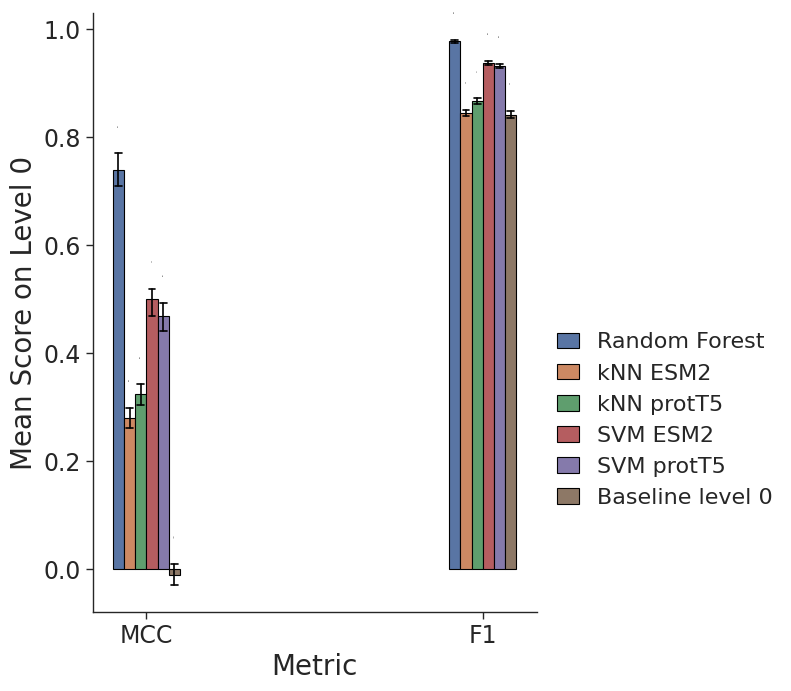

In [7]:

# l0
plot_bootstrapped_score(y_trues_l0,
                        y_preds_l0,
                        scoring_funcs=scoring_funcs,
                        model_names=[
                         "Random Forest",
                         "kNN ESM2",
                         "kNN protT5",
                         "SVM ESM2",
                         "SVM protT5",
                         "Baseline level 0"
                        ],
                        level=0,
                        score_display_size=0)



              Model Metric Mean Score     SE      CI_0      CI_1
0          FNN ESM2    MCC       0.94  0.014   0.91086   0.96623
1          FNN ESM2     F1       0.95  0.011  0.932316  0.974177
0        FNN ProtT5    MCC       0.66  0.027  0.607232  0.714435
1        FNN ProtT5     F1       0.72  0.024  0.673262  0.766869
0             CLEAN    MCC       0.92  0.015  0.892294  0.950946
1             CLEAN     F1       0.94  0.011  0.923195  0.964391
0          CNN ESM2    MCC       0.65  0.029  0.587573  0.702155
1          CNN ESM2     F1       0.73  0.023  0.681064  0.769362
0        CNN ProtT5    MCC       0.58   0.03  0.521501  0.640421
1        CNN ProtT5     F1       0.67  0.025  0.617143  0.712927
0  Baseline Level 1    MCC      -0.01   0.02 -0.048534  0.031678
1  Baseline Level 1     F1       0.15   0.02  0.113713  0.192406


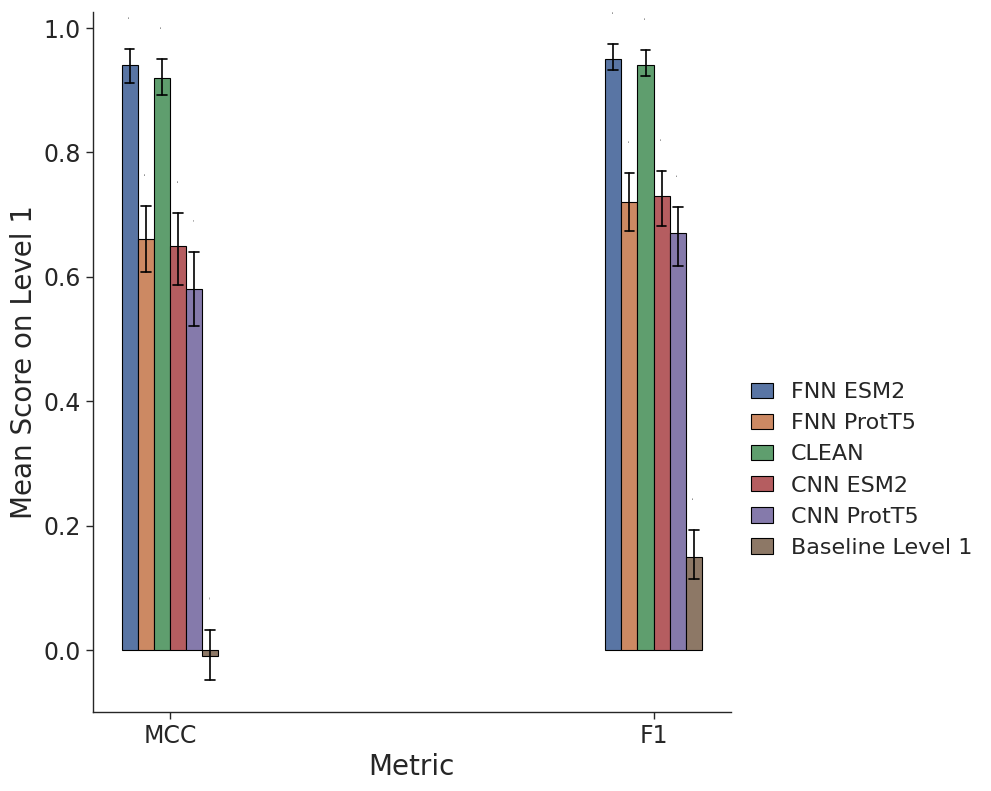

In [8]:
# l1
plot_bootstrapped_score(y_trues_l1,
                        y_preds_l1,
                        scoring_funcs=scoring_funcs,
                        model_names=
                        ["FNN ESM2",
                         "FNN ProtT5",
                         "CLEAN", 
                         "CNN ESM2",
                         "CNN ProtT5", 
                         "Baseline Level 1"], 
                        level=1,
                        width=10,
                        height=8,
                        score_display_size=0)


              Model Metric Mean Score      SE      CI_0      CI_1
0               FNN    MCC       0.79   0.021  0.744488  0.825907
1               FNN     F1       0.81   0.021  0.770828  0.852688
0             CLEAN    MCC       0.88   0.017  0.847503  0.913928
1             CLEAN     F1        0.9   0.016  0.864435  0.926891
0  Baseline level 2    MCC      0.005  0.0097 -0.012736  0.025166
1  Baseline level 2     F1       0.03   0.011  0.008226  0.048887


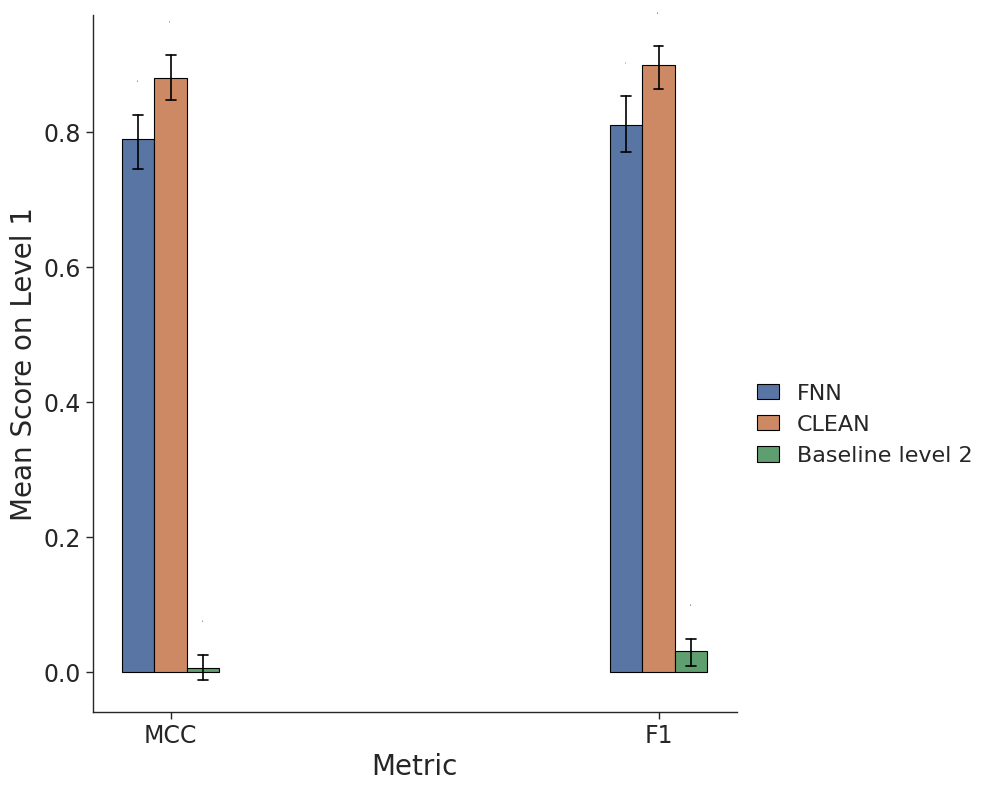

In [9]:
# l2
plot_bootstrapped_score(y_trues_l2,
                        y_preds_l2,
                        scoring_funcs=scoring_funcs,
                        model_names=
                        ["FNN", "CLEAN", "Baseline level 2"],
                        level=1,
                        width=10,
                        height=8,
                        score_display_size=0)
